# Setup

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Exploratory data analysis 
import pandas_profiling
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

# Custom package
import tools_repo as tr

# Set notebook options
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 10000)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

# Pretty display of multiple functions in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# File Location

In [2]:
# file paths
INTERIM_FILEPATH = '../data/interim/'

INTERIM_FILENAME_V1 = 'employee_churn_data_v1'
INTERIM_FILENAME_V2 = 'employee_churn_data_v2'

# Load Data 

In [3]:
master = pd.read_csv(INTERIM_FILEPATH + INTERIM_FILENAME_V1 + '.csv')
# master.info()

In [4]:
master.shape; master.head(2)

(9540, 16)

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,satisfaction.group2,satisfaction.group3,review.group2,review.group3,avg_hrs_month.group2,avg_hrs_month.group3
0,operations,0,0.58,3,low,5.00,0.63,0,180.87,no,0.5_0.699,passives,0.0_0.599,subpar performers,0_184.99,short-hour workers
1,operations,0,0.75,3,medium,6.00,0.44,0,182.71,no,0.0_0.499,detractors,0.7+,high performers,0_184.99,short-hour workers


# Univariate Analysis

In [5]:
prof = ProfileReport(master, minimal=True) #
prof.to_file(output_file='../reports/figures/eda_output_minimal.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Clean Data

## check data sparsity

In [6]:
#convert each column to SparseArray
sparr = master.apply(pd.arrays.SparseArray)
# print (sparr)
# print (sparr.dtypes)

In [7]:
print (sparr.sparse.density)

0.890146750524109


In [8]:
a = (master.to_numpy() == 0).mean()
print (a)

0.10985980083857443


## check for and treat missing values

In [9]:
master.isnull().sum()

department              0
promoted                0
review                  0
projects                0
salary                  0
tenure                  0
satisfaction            0
bonus                   0
avg_hrs_month           0
left                    0
satisfaction.group2     0
satisfaction.group3     0
review.group2           0
review.group3           0
avg_hrs_month.group2    0
avg_hrs_month.group3    0
dtype: int64

In [10]:
master.dtypes

department               object
promoted                  int64
review                  float64
projects                  int64
salary                   object
tenure                  float64
satisfaction            float64
bonus                     int64
avg_hrs_month           float64
left                     object
satisfaction.group2      object
satisfaction.group3      object
review.group2            object
review.group3            object
avg_hrs_month.group2     object
avg_hrs_month.group3     object
dtype: object

In [11]:
cols = ['promoted', 'bonus', 'tenure', 'projects']
for col in cols:
    master[col] = master[col].astype('O')

In [12]:
master_sub1 = master.copy()

## check for and drop high cardinality variables

In [13]:
high_cardinality_cols = tr.find_high_cardinality(master_sub1);  high_cardinality_cols

0 categorical variables have more than 20 unique levels.


[]

In [14]:
master_sub2 = master_sub1.drop(high_cardinality_cols, axis=1)

In [15]:
master_sub2.shape; master_sub2.head(2)

(9540, 16)

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left,satisfaction.group2,satisfaction.group3,review.group2,review.group3,avg_hrs_month.group2,avg_hrs_month.group3
0,operations,0,0.58,3,low,5.00,0.63,0,180.87,no,0.5_0.699,passives,0.0_0.599,subpar performers,0_184.99,short-hour workers
1,operations,0,0.75,3,medium,6.00,0.44,0,182.71,no,0.0_0.499,detractors,0.7+,high performers,0_184.99,short-hour workers


## check for and drop zero-variance variables

In [16]:
tr.find_low_variance(master_sub2)

[]

# Initial Feature Selection

In [17]:
drop_col = ['avg_hrs_month.group2', 'review.group2', 'satisfaction.group2']

In [18]:
master_sub3 = master_sub2.drop(drop_col, axis=1)

# Distribution Analysis

## data creation

#### numerical features

In [19]:
# master_sub3.dtypes

In [20]:
master_sub3 = master_sub3.copy()

In [21]:
num_cols = list(master_sub3.select_dtypes(include=['float64', 'int64']).columns)

In [22]:
num_corr_check = tr.check_category_numerical_correlation(master, 'left', num_cols)
num_corr_check

,Variable,P-value
0,review,0.00
1,satisfaction,0.34
2,avg_hrs_month,0.38


In [23]:
# select_num_cols = list(num_corr_check[~(num_corr_check['P-value'] > 0.05)]['Variable']); len(select_num_cols); #select_num_cols 

In [24]:
num_data = master_sub3[num_cols]; num_data.shape

(9540, 3)

#### categorical features

In [25]:
master_sub3 = master_sub3.copy()

In [26]:
cat_cols = list(master_sub3.select_dtypes(include=['object']).columns); len(cat_cols)#; cat_cols

10

In [27]:
cat_data = master_sub3[cat_cols]

In [28]:
target = 'left'
select_cat_cols = [i for i in cat_cols if i != target]; len(select_cat_cols)

9

## correlation analysis

#### numerical features : pearson correlation coefficient

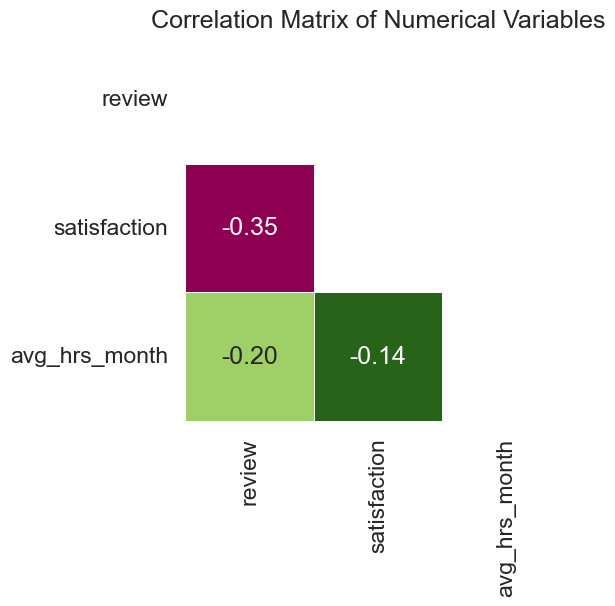

In [29]:
tr.corr_plot(num_data, figsize=(5,5))

In [30]:
# cor_matrix = num_data.corr().abs()
# upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
# to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
# # print(list(to_drop))

In [31]:
# num_data_clean = num_data.drop(to_drop, axis=1); num_data_clean.shape

In [32]:
# tr.corr_plot(num_data_clean, figsize=(30,30))

#### categorical features

In [33]:
tr.nom_stats(cat_data)


department: 
Unique levels: 10
   Variable  Count  Proportion
      sales   1883        0.20
     retail   1541        0.16
 operations   1522        0.16
engineering   1516        0.16
  marketing    802        0.08
    support    735        0.08
      admin    423        0.04
    finance    402        0.04
  logistics    360        0.04
         IT    356        0.04

promoted: 
Unique levels: 2
 Variable  Count  Proportion
        0   9251        0.97
        1    289        0.03

projects: 
Unique levels: 4
 Variable  Count  Proportion
        3   5833        0.61
        4   3058        0.32
        2    578        0.06
        5     71        0.01

salary: 
Unique levels: 3
Variable  Count  Proportion
  medium   6611        0.69
    high   1548        0.16
     low   1381        0.14

tenure: 
Unique levels: 11
 Variable  Count  Proportion
     6.00   2313        0.24
     7.00   2209        0.23
     8.00   1888        0.20
     5.00   1823        0.19
     9.00    578        0

In [34]:
master_sub3['left_num'] = master_sub3['left'].map({'no':0, 'yes':1})

In [35]:
# df_num_data_target = pd.merge(num_data, master_sub3['left_num'], left_index=True, right_index=True, how='left')

In [36]:
num_data.shape; num_data.head(2)

(9540, 3)

,review,satisfaction,avg_hrs_month
0,0.58,0.63,180.87
1,0.75,0.44,182.71


In [37]:
print(list(num_data))

['review', 'satisfaction', 'avg_hrs_month']


## target variable

In [38]:
master_sub3['counter'] = 1

In [39]:
attrition_prop = master_sub3[['left', 'counter']].groupby(['left']).count()/master_sub3.shape[0] 

In [40]:
attrition_prop

,counter
left,
no,0.71
yes,0.29


C:\Users\yvett\AppData\Local\Temp\ipykernel_21540\1326331039.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])


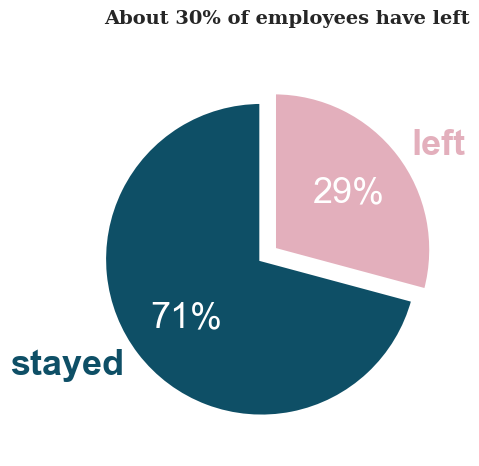

In [41]:
fig = plt.subplots(subplot_kw=dict(aspect="equal"),figsize=(15, 5))
gs= gridspec.GridSpec(1,2, width_ratios=[2,2])

ax1 = plt.subplot(gs[0])

patches, texts, pcts = ax1.pie(attrition_prop['counter'],
        labels = ['stayed', 'left'],
        autopct='%0.0f%%',
        colors = ('#0e4f66', '#e3afbc'),
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'},
    startangle=90,
    explode=(0, 0.1))

for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white')
plt.setp(texts, fontweight=600)

ax1.text(-1.0, 1.5, 'About 30% of employees have left', fontsize=14, fontweight='bold', fontfamily='serif')

plt.tight_layout()
plt.savefig('../reports/figures/imbalance in target.png', bbox_inches='tight')
plt.show();

## input variables

In [42]:
colors = ["#0e4f66", "#e3afbc"]

# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

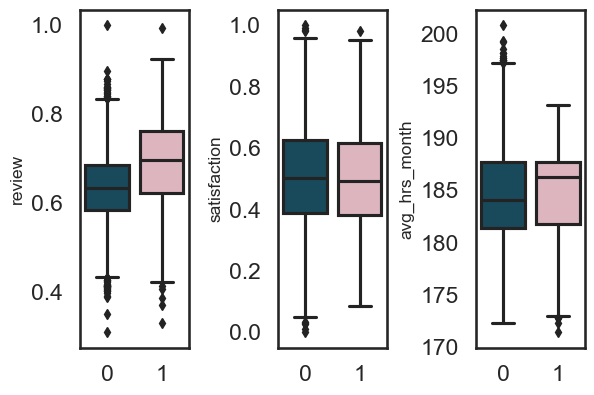

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=len(num_data.columns), figsize=(len(num_data.columns)*2,4))
for index, col in enumerate(num_data.columns):
    ax = axes[index]
    sns.boxplot(y=master_sub3.loc[:,col], x=master_sub3.loc[:,'left_num'], palette=customPalette, ax=ax)
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-small')
    ax.set_xlabel("")
#     ax.tick_params(labelsize=6)
plt.tight_layout(pad=0.5)
plt.show();

In [44]:
target_order = [0,1]

C:\Users\yvett\anaconda3\envs\employee-attrition-python\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


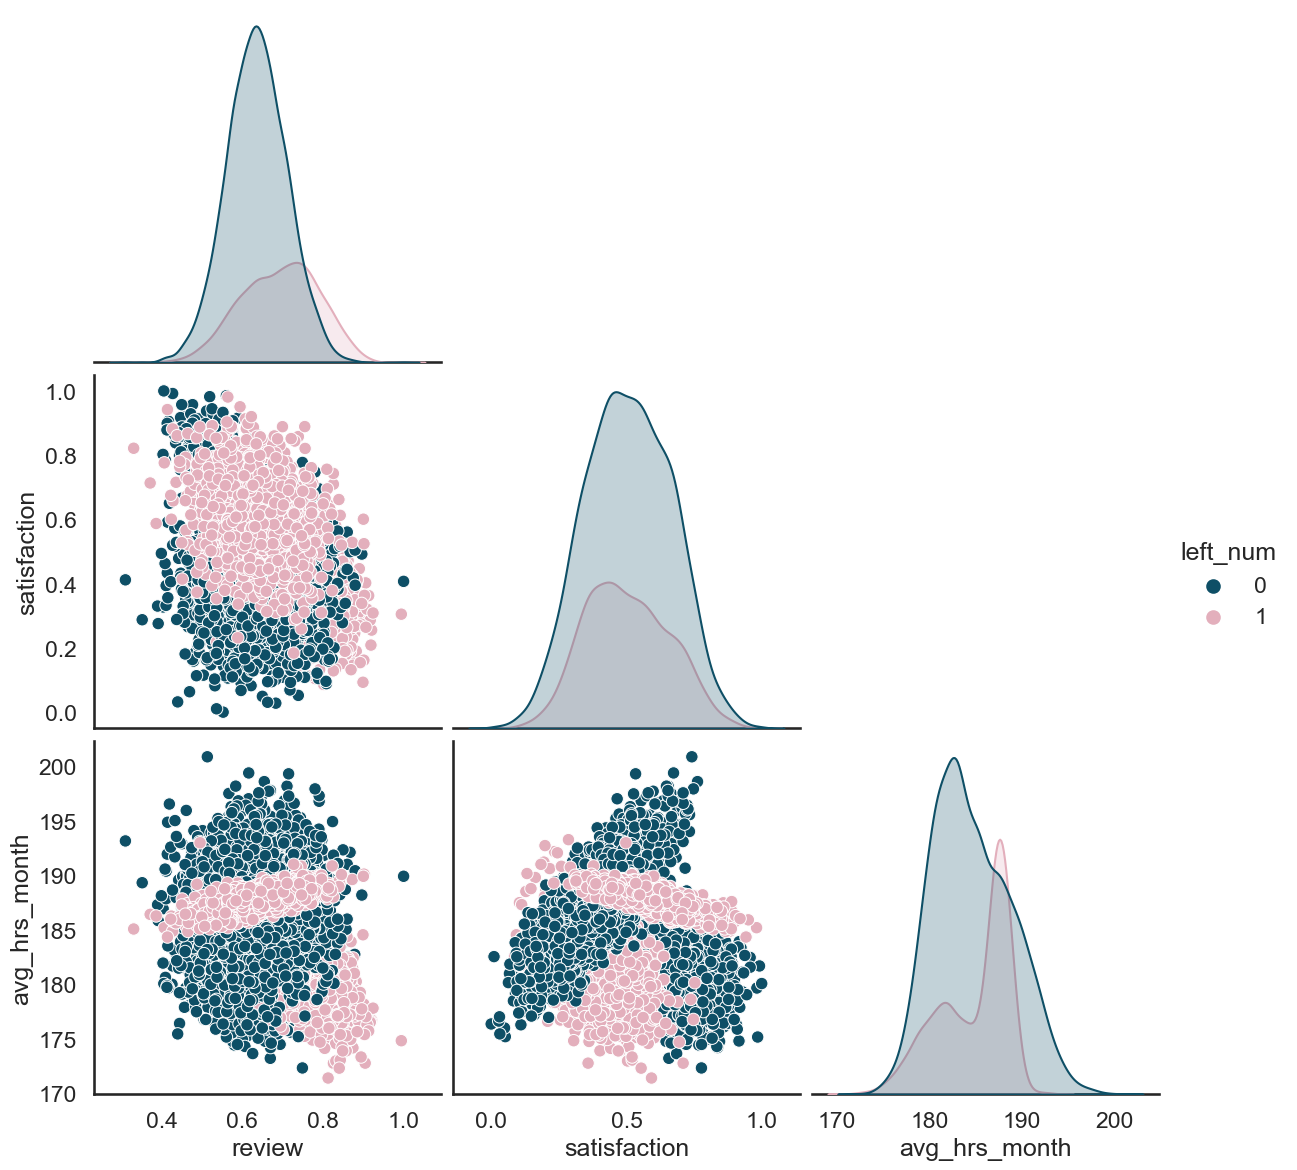

In [45]:
g = sns.pairplot(data=master_sub3, 
                 vars=num_data.columns, 
                 hue='left_num',            
                 corner=True,
                 hue_order=target_order, size=4)

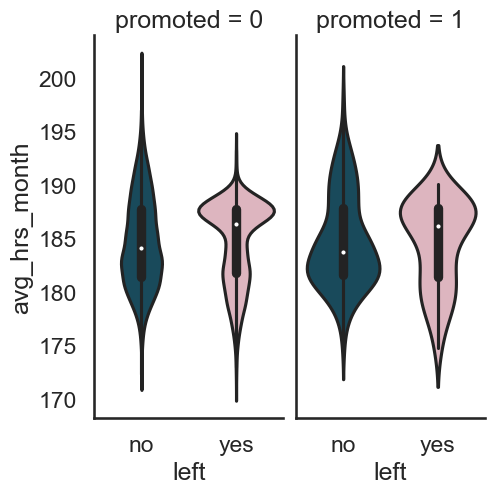

In [46]:
g = sns.catplot(x="left", 
                y="avg_hrs_month",
                col="promoted", 
                aspect=0.5,
                dodge=True,
                kind="violin", orient='v',
                data=master_sub3, palette=customPalette);
plt.tight_layout(pad=0.5)
plt.show();
# g.set(yscale="log");

In [47]:
# master_sub3.describe().transpose()

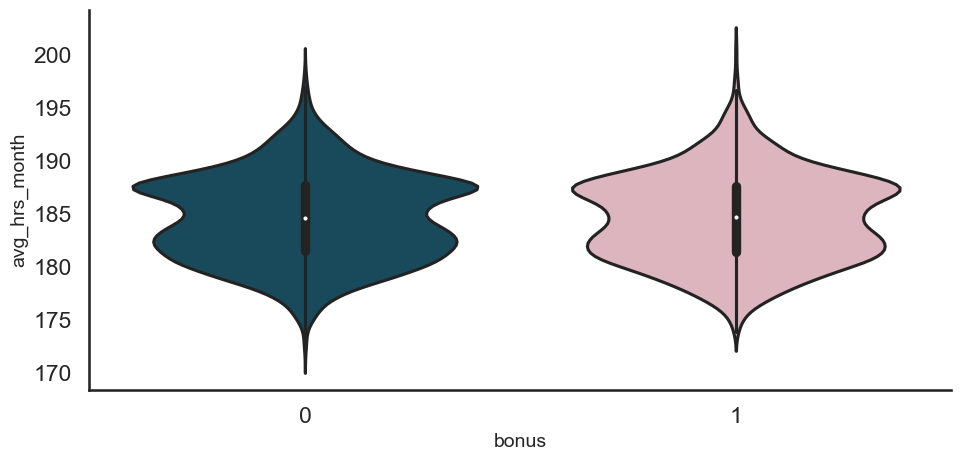

In [48]:
vio_plot = sns.catplot(x="bonus", y="avg_hrs_month", kind="violin", aspect=2,data=master_sub3)
plt.xlabel("bonus", size=14)
plt.ylabel("avg_hrs_month", size=14);

In [49]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(-0.1, .2, label, fontweight="bold", color="black",
            ha="left", va="center", transform=ax.transAxes)

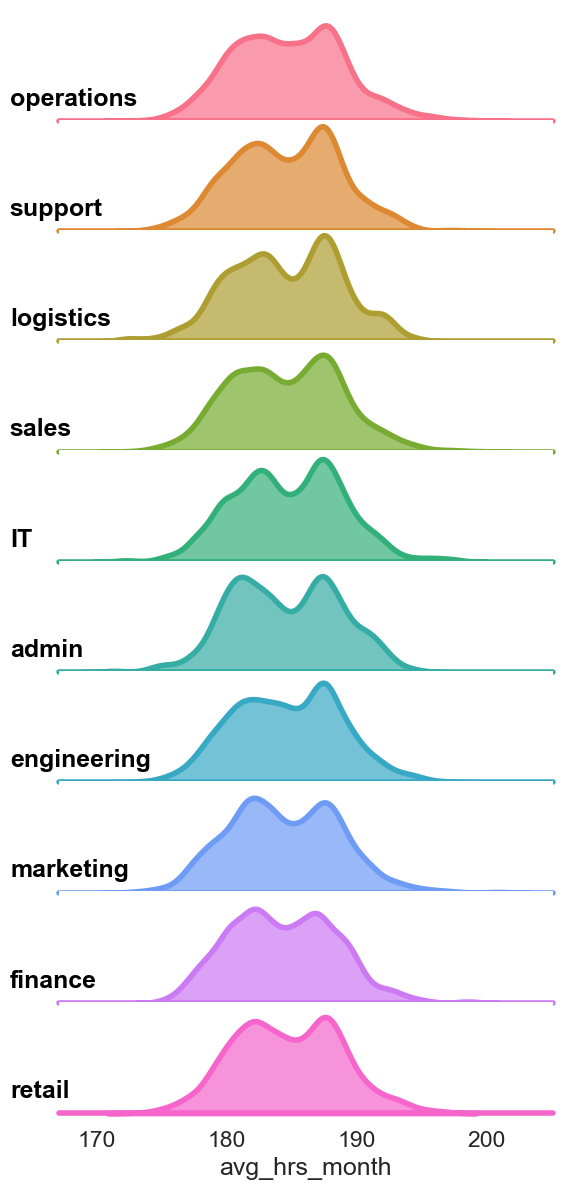

In [50]:
ridge_plot = sns.FacetGrid(master_sub3, row="department", hue="department", aspect=5, height=1.25)
# Draw the densities in a few steps
ridge_plot.map(sns.kdeplot, "avg_hrs_month", clip_on=False, fill=True, alpha=0.7, lw=4, bw_method=.2, warn_singular=False)
#g.map(sns.kdeplot, "co2_emission", clip_on=False, color="b", lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "avg_hrs_month")
# Set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.01)
# Remove axes details that don't play well with overlap
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.set(ylabel=None)
ridge_plot.despine(bottom=True, left=True);

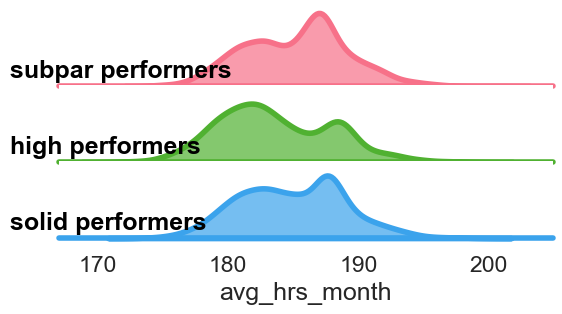

In [51]:
ridge_plot = sns.FacetGrid(master_sub3, row="review.group3", hue="review.group3", aspect=5, height=1.25)
# Draw the densities in a few steps
ridge_plot.map(sns.kdeplot, "avg_hrs_month", clip_on=False, fill=True, alpha=0.7, lw=4, bw_method=.2, warn_singular=False)
#g.map(sns.kdeplot, "co2_emission", clip_on=False, color="b", lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "avg_hrs_month")
# Set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.01)
# Remove axes details that don't play well with overlap
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.set(ylabel=None)
ridge_plot.despine(bottom=True, left=True);

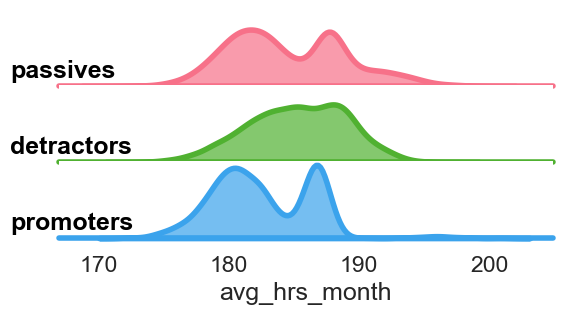

In [52]:
ridge_plot = sns.FacetGrid(master_sub3, row="satisfaction.group3", hue="satisfaction.group3", aspect=5, height=1.25)
# Draw the densities in a few steps
ridge_plot.map(sns.kdeplot, "avg_hrs_month", clip_on=False, fill=True, alpha=0.7, lw=4, bw_method=.2, warn_singular=False)
#g.map(sns.kdeplot, "co2_emission", clip_on=False, color="b", lw=4, bw=.2)
ridge_plot.map(plt.axhline, y=0, lw=4, clip_on=False)
ridge_plot.map(label, "avg_hrs_month")
# Set the subplots to overlap
ridge_plot.fig.subplots_adjust(hspace=-0.01)
# Remove axes details that don't play well with overlap
ridge_plot.set_titles("")
ridge_plot.set(yticks=[])
ridge_plot.set(ylabel=None)
ridge_plot.despine(bottom=True, left=True);

## Export Data

In [53]:
master_sub3.to_csv(INTERIM_FILEPATH + INTERIM_FILENAME_V2 + '.csv', index=False)